### Распространение тепла

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
from tqdm import trange
from matplotlib import gridspec
from scipy import signal

### Карта коэффициентов диффузии

In [2]:
def diffusion(N, W, H, D0, D1):
    '''
    Аргументы:
        N (int): количество точек (разрешение)
        W (int): ширина
        H (int): высота
        D0 (float): основной коэффициент диффузии
        D1 (float): коэффициент диффузии вставки

    Генерирует карту диффузии (для варианта 8)
    '''
    
    D = np.full((N, N), D0)
    dh = N // H
    dw = N // W
    
    D[30 * dh : 50 * dh + 1, 10 * dw : 30 * dw + 1] = D1
    D[35 * dh : 45 * dh + 1, 15 * dw : 25 * dw + 1] = D0
    D[35 * dh : 40 * dh + 1, 10 * dw : 15 * dw + 1] = D0
    
    return D

### Одна итерация

In [3]:
@njit(parallel=True)
def diffuse_step(N, it, T, dx, dt, D):
    '''
    Аргументы:
        N (int): количество точек (разрешение)
        it (int): текущая итерация
        T (np.array): карта температур
        dx (float): шаг
        dt (float): шаг по времени
        D (np.array): карта диффузии

    Делает одну итерацию диффузии
    '''
    
    prev = it % 2 #карта температур "разделена" на две части - текущую и предыдущую
    cur = (it + 1) % 2 #на каждом шаге предыдущая часть обновляется до текущей

    for i in prange(1, N-1):
        for j in range(1, N-1):
            g = dt * D[i, j] / dx ** 2
            T[cur, i, j] = T[prev, i, j]   + g * (
                         T[prev, i + 1, j] +
                         T[prev, i - 1, j] +
                         T[prev, i, j - 1] +
                         T[prev, i, j + 1] -
                     4 * T[prev, i, j]           )

### Граничные условия

In [4]:
def bound(T):
    '''
    Аргументы:
        T (np.array): карта температур

    Выполнение граничных условий
    '''
    T[:,  0,  :] = 0
    T[:,  :,  0] = 0
    T[:, -1,  :] = T[:, -2,  :]
    T[:,  :, -1] = T[:,  :, -2]

### Источники тепла

In [5]:
def q(p, theta, dt):
    '''
    Аргументы:
        p (float): параметр p*
        theta (float): параметр theta*
        dt (float): шаг по времени

    Вычисляет величину q по формуле p*sin((2*pi*dt) / theta + 1)
    '''
    return p * (np.sin(2 * np.pi * dt / theta) + 1)

In [6]:
def heat(T, source, dw, dh, iteration, dt):
    '''
    Аргументы:
        T (np.array): карта температур
        source (list): параметры источника тепла (см. source())
        dw (float): масштаб по ширине
        dh (float): масштаб по высоте
        iteration (int): текущая итерация
        dt (float): шаг по времени

        Вычисляет величину нагрева и учитывает его в карте температур для источника тепла
    '''
    T[:, source[2] * dh : source[3] * dh, source[0] * dw : source[1] * dw] += dt * q(source[4], source[5], iteration * dt)

In [7]:
def source(x_left, x_right, y_lower, y_upper, p, theta):
    '''
    Аргументы:
        x_left (int): координата левой границы нагревательного элемента
        x_right (int): координата правой границы нагревательного элемента
        y_lower (int): координата нижней границы нагревательного элемента
        y_upper (int): координата верхней границы нагревательного элемента
        p (float): см. q
        theta (float): см. q 

    Задает источник тепла
    '''
    return [x_left, x_right, y_lower, y_upper, p, theta]

### Распространение тепла

In [8]:
def heat_transfer(N, W, H, D, sources, dt = 0.05, t_max = 600):
    '''
    Аргументы:
        N (int): количество точек (разрешение)
        W (int): ширина
        H (int): высота
        D (np.array): карта диффузии
        sources (list): список источников тепла (см. source())
        dt (float): шаг по времени
        t_max (int): максимальное время

        Строит карту температур, замеряет температуру в местах установки проб, сохраняет результаты в файл
    '''
    dx = W / N
    dy = H / N
    dw = N // W
    dh = N // H
    it_max = int(t_max / dt)

    T = np.zeros((2, N, N))
    
    res0 = []
    res1 = []
    res2 = []
    res3 = []

    for it in trange(it_max):
        
        for source in sources:
            heat(T, source, dw, dh, it, dt)
        bound(T)
        diffuse_step(N, it, T, dx, dt, D)
    
        res0.append(T[0, 20 * dh, 20 * dw])
        res1.append(T[0, 40 * dh, 20 * dw])
        res2.append(T[0, 40 * dh, 40 * dw])
        res3.append(T[0, 20 * dh, 40 * dw])
        
    np.save('temperature_'+str(N)+'.npy', T)
    np.save('probe0_' + str(N) + '.npy', res0)
    np.save('probe1_' + str(N) + '.npy', res1)
    np.save('probe2_' + str(N) + '.npy', res2)
    np.save('probe3_' + str(N) + '.npy', res3)
    

### Периоды колебаний

In [9]:
def period(temp, dt):
    '''
    Аргументы:
        temp (np.array): массив (температур)
        dt (float): шаг по времени

    Находит периоды колебаний используя быстрое преобразование Фурье
    '''
    fft_temp = np.fft.rfft(temp)
    freqs = np.fft.rfftfreq(len(temp), dt)
    idx = np.argmax(np.abs(fft_temp), axis=0)
    peaks, _ = signal.find_peaks(np.abs(fft_temp))
    period = 1 / freqs[peaks]
    return period

### Изображения и графики

In [10]:
def picture(N, W, H, D, dt):
    '''
    Аргументы:
        N (int): количество точек (разрешение)
        W (int): ширина
        H (int): высота
        D (np.array): карта диффузии
        dt (float): шаг по времени (для вывода периода колебаний)

        Выводит карту температур, графики температуры в местах установки проб и карту коэффициентов диффузии
    '''
    dw = N // W
    dh = N // H
    
    T = np.load('temperature_'+str(N)+'.npy')
    res0 = np.load('probe0_' + str(N) + '.npy')
    res1 = np.load('probe1_' + str(N) + '.npy')
    res2 = np.load('probe2_' + str(N) + '.npy')
    res3 = np.load('probe3_' + str(N) + '.npy')

    print('0:', *period(res0, dt), sep='\t')
    print('1:', *period(res1, dt), sep='\t')
    print('2:', *period(res2, dt), sep='\t')
    print('3:', *period(res3, dt), sep='\t')
    
    plt.figure(figsize=(10, 8))

    
    plt.axis('equal')
    plt.title('Карта температур')
    plt.pcolormesh(T[0], cmap='magma')
    plt.colorbar()
    plt.scatter(20 * dh, 20 * dw, label='0')
    plt.scatter(20 * dh, 40 * dw, label='1')
    plt.scatter(40 * dh, 40 * dw, label='2')
    plt.scatter(40 * dh, 20 * dw, label='3')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 3))
    g = gridspec.GridSpec(1, 2, width_ratios=[5, 2]) 
    plt.subplot(g[0])
    plt.plot(res0, label='0')
    plt.plot(res1, label='1')
    plt.plot(res2, label='2')
    plt.plot(res3, label='3')
    plt.title('Пробы')
    plt.xlabel('Время')
    plt.ylabel('Температура')
    plt.legend()

    plt.subplot(g[1])
    plt.axis('equal')
    plt.title('Коэффициенты диффузии')
    plt.pcolormesh(D, cmap = 'winter')
    plt.show()


### Общие параметры

In [11]:
W, H = 60, 60
D0 = 1
D1 = 0.01
sources = [source(5, 10, 20, 40, 100, 43), source(20, 40 , 5, 10, 100, 77)]
t_max = 600

### N = 60, dt = 0.05

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:01<00:00, 8709.05it/s]


0:	75.0	42.857142857142854	0.1002171371304493	0.10011680293675955
1:	42.857142857142854	0.10055304172951232	0.10023387905111927
2:	0.1001335113484646	0.10010010010010009
3:	75.0	0.10011680293675955


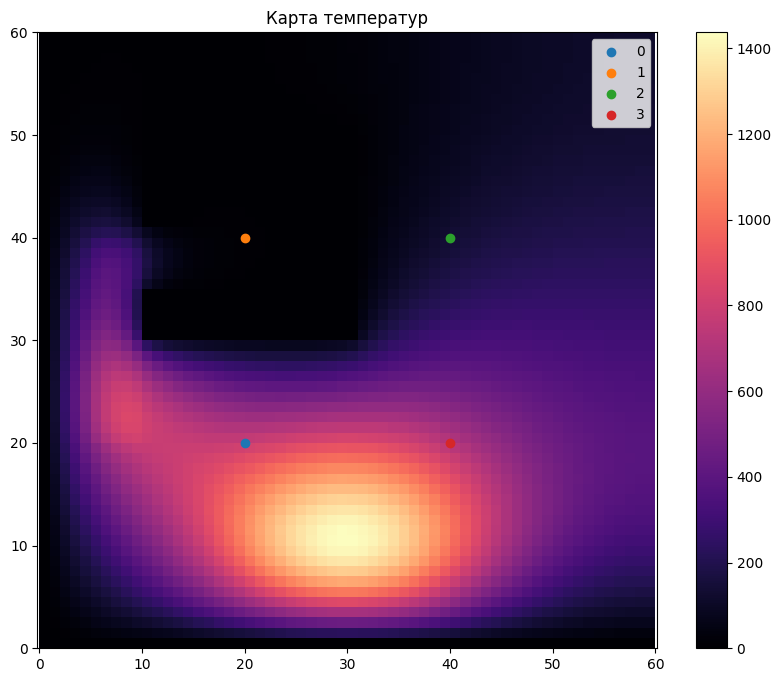

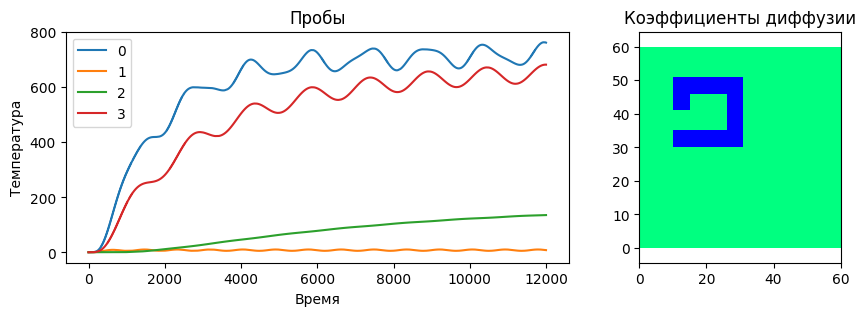

In [12]:
N = 60
dt = 0.05
D = diffusion(N, W, H, D0, D1)
heat_transfer(N, W, H, D, sources, dt, t_max)
picture(N, W, H, D, dt)

### N =120, dt = 0.0125

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48000/48000 [00:02<00:00, 21553.64it/s]


0:	75.0	42.857142857142854	0.025013549005711424	0.025007293794023253
1:	42.857142857142854	0.025038601176814255	0.02501459184524306
2:	0.025008336112037344	0.02500625156289072
3:	75.0	0.025007293794023253


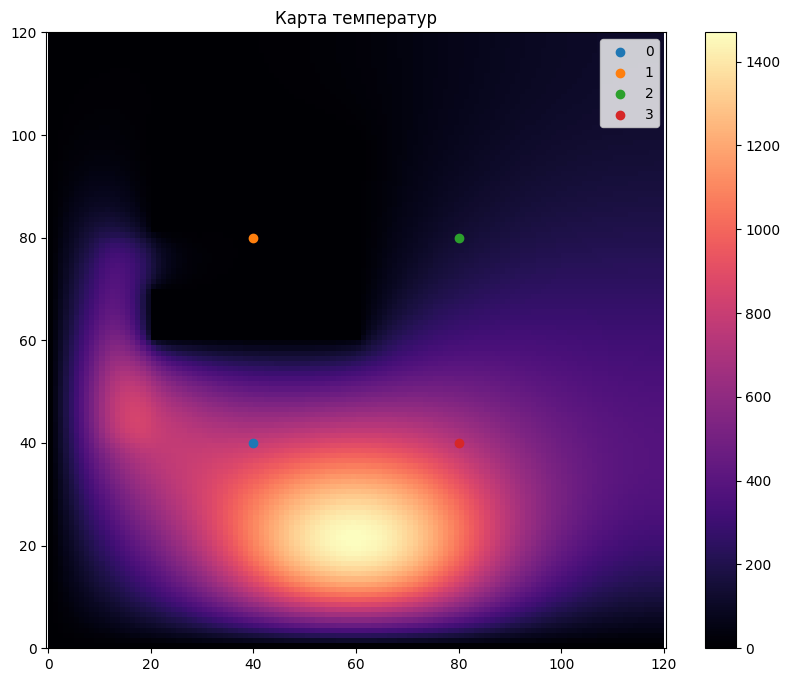

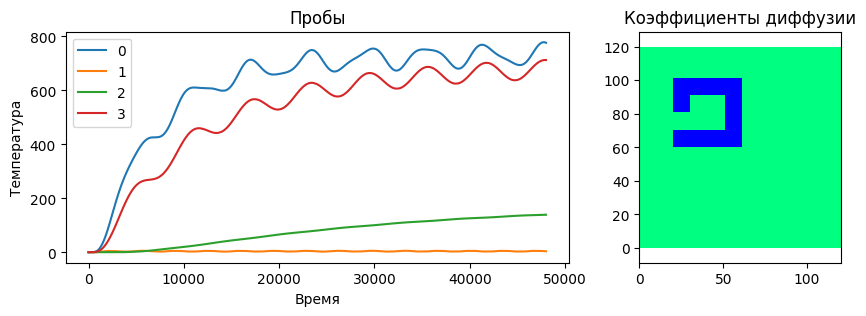

In [13]:
N = 120
dt = 0.0125
D = diffusion(N, W, H, D0, D1)
heat_transfer(N, W, H, D, sources, dt, t_max)
picture(N, W, H, D, dt)

### N = 240, dt = 0.003

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [00:13<00:00, 14986.44it/s]


0:	75.0	42.857142857142854	0.006000780101413183	0.006000420029402058
1:	42.857142857142854	0.006002400960384153	0.0060008401176164655
2:	0.006000480038403072	0.006000360021601296
3:	75.0	0.006000420029402058


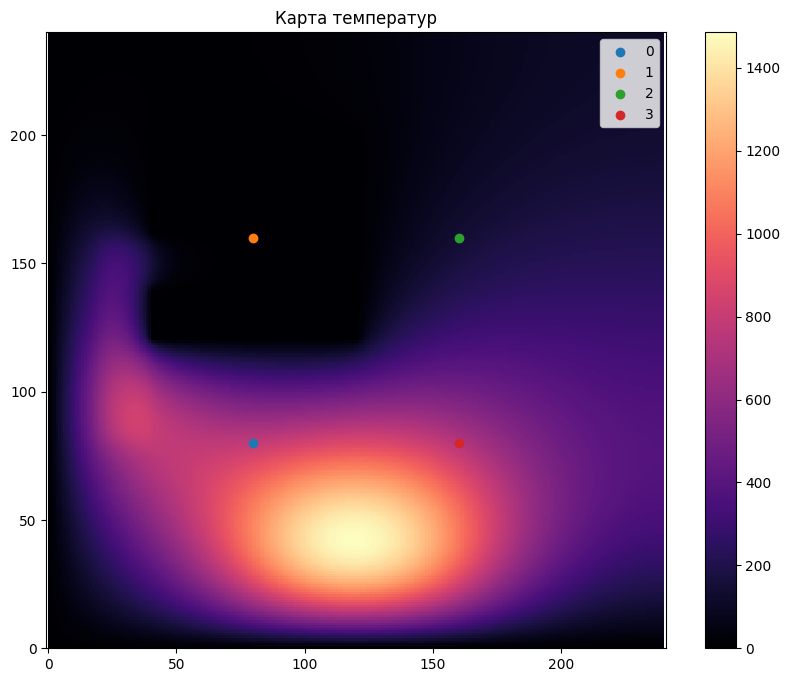

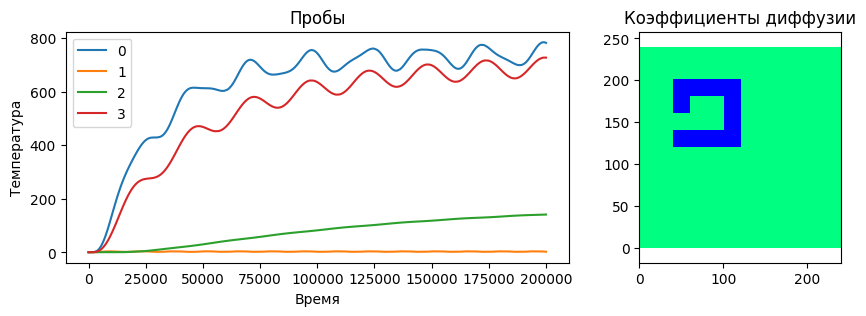

In [14]:
N = 240
dt = 0.003
D = diffusion(N, W, H, D0, D1)
heat_transfer(N, W, H, D, sources, dt, t_max)
picture(N, W, H, D, dt)

### N = 480, dt = 0.0008

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750000/750000 [01:43<00:00, 7230.57it/s]


0:	75.0	42.857142857142854	0.0016000554685895777	0.001600029867224188
1:	42.857142857142854	0.001600174952461469	0.001600059735563461
2:	0.0016000341340615266	0.0016000256004096065
3:	75.0	0.001600029867224188


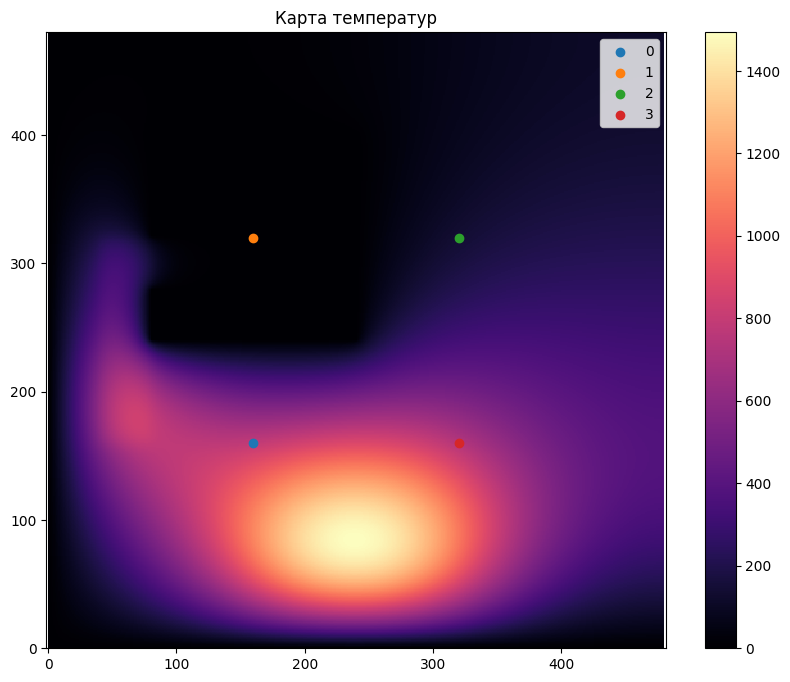

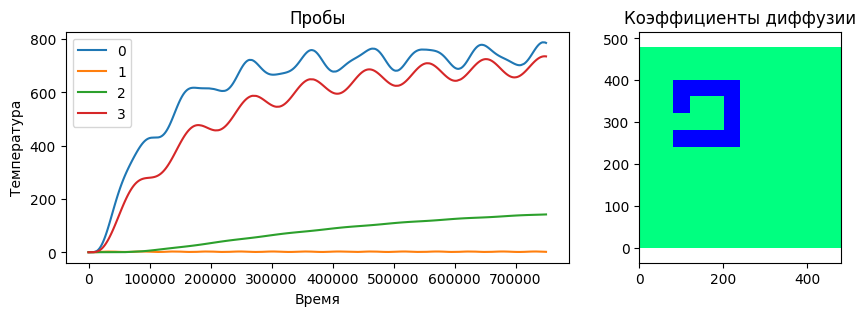

In [15]:
N = 480
dt = 0.0008
D = diffusion(N, W, H, D0, D1)
heat_transfer(N, W, H, D, sources, dt, t_max)
picture(N, W, H, D, dt)

### N = 960, dt = 0.0002

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000000/3000000 [1:08:15<00:00, 732.42it/s]


0:	75.0	42.857142857142854	0.00040000346669671135	0.00040000186667537777
1:	42.857142857142854	0.0004000112003136087	0.00040000373336817805
2:	0.0004000021333447112	0.0004000016000064
3:	75.0	0.00040000186667537777


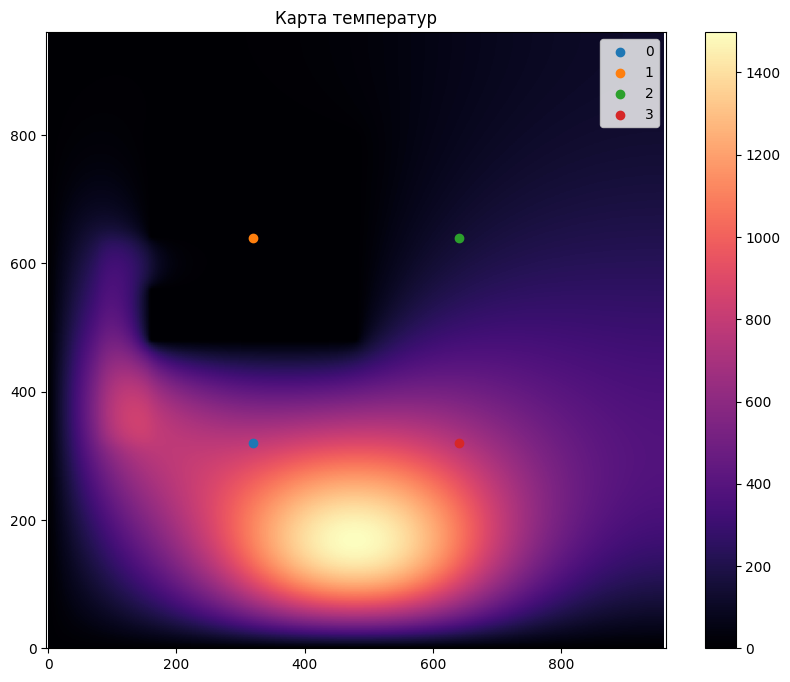

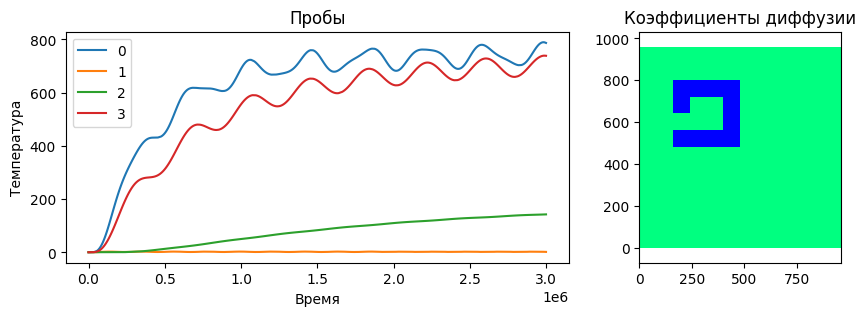

In [16]:
N = 960
dt = 0.0002
D = diffusion(N, W, H, D0, D1)
heat_transfer(N, W, H, D, sources, dt, t_max)
picture(N, W, H, D, dt)